In [2]:
import os
import re
import cv2
import shutil
import random
import numpy as np
import seaborn as sns
import keras_tuner as kt
import matplotlib.pyplot as plt

In [3]:
from PIL import Image
from glob import glob
from keras.models import Model
from keras.applications import VGG16
from tensorflow.keras.models import load_model
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Conv2D, Conv2DTranspose, Add, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
train_images_path = 'Dataset/images_prepped_train-20230811T065243Z-001/images_prepped_train/'
train_anntotations_path = 'Dataset/annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train/'

In [5]:
test_images_path = 'Dataset/images_prepped_test-20230811T065241Z-001/images_prepped_test/'
test_anntotations_path = 'Dataset/annotations_prepped_test-20230811T065240Z-001/annotations_prepped_test/'

In [6]:
width = 256
height = 256
classes = 13
batch_size = 32
num_of_training_samples = len(os.listdir(train_images_path)) 
num_of_testing_samples = len(os.listdir(test_images_path))

In [7]:
def LoadImage(image_name, image_path, mask_name, mask_path):
    image = Image.open(os.path.join(image_path, image_name))
    mask = Image.open(os.path.join(mask_path, mask_name))

    image = image.resize((width, height))
    mask = mask.resize((width, height))

    image = np.array(image)
    mask = np.array(image)

    return image, mask

In [8]:
def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)

    return new_mask

In [9]:
def getSegmentationArr(image, classes, width=width, height=height):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, :, 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c).astype(int)

    return seg_labels

In [10]:
def give_color_to_seg_img(seg, n_classes=classes):
    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3)).astype('float')
    colors = sns.color_palette('hls', n_classes)

    for c in range(n_classes):
        segc = (seg == c)

        seg_img[:, :, 0] += (segc * (colors[c][0]))
        seg_img[:, :, 1] += (segc * (colors[c][1]))
        seg_img[:, :, 2] += (segc * (colors[c][2]))

    return (seg_img)

In [11]:
def DataGenerator(image_path, mask_path, batch_size=batch_size, classes=classes):
    image_files = os.listdir(image_path)
    mask_files = os.listdir(mask_path)

    while True:
        for i in range(0, len(image_files), batch_size):
            images_batch = image_files[i : i + batch_size]
            masks_batch = mask_files[i : i + batch_size]

            imgs = []
            segs = []
            for j, (image_file, mask_file) in enumerate(zip(images_batch, masks_batch)):
                image, mask = LoadImage(image_file, image_path, mask_file, mask_path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

In [12]:
train_gen = DataGenerator(train_images_path, train_anntotations_path, batch_size=batch_size)
val_gen = DataGenerator(test_images_path, test_anntotations_path, batch_size=batch_size)

In [13]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((32, 256, 256, 3), (32, 256, 256, 13))

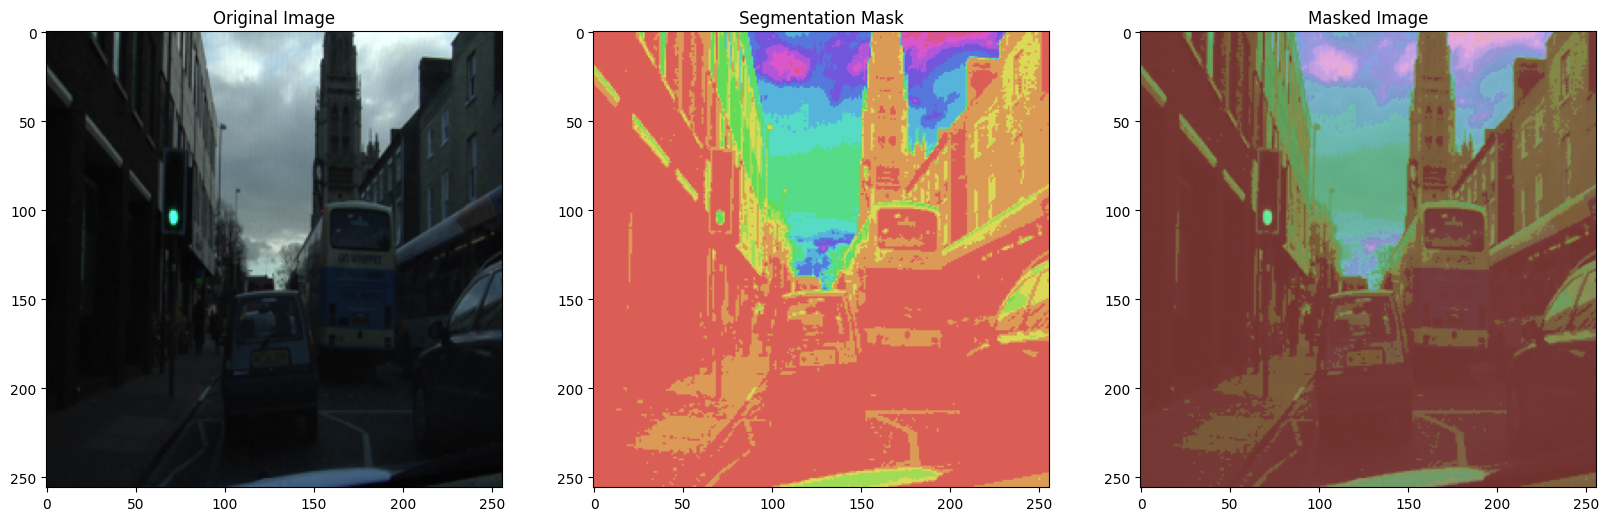

In [14]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image / 255, 0.5, mask, 0.5, 0)

fig, axs = plt.subplots(1, 3, figsize=(20, 20))

axs[0].imshow(image)
axs[0].set_title('Original Image')

axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')

axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')

plt.show()

In [15]:
def rename_file_if_exists(file_path):
    if not os.path.exists(file_path):
        return file_path

    index = 1
    base_name, ext = os.path.splitext(file_path)
    new_file_path = f'{base_name}_{index}{ext}'

    while os.path.exists(new_file_path):
        index += 1
        new_file_path = f'{base_name}_{index}{ext}'

    return new_file_path

In [16]:
varian = ['32s', '16s', '8s']
tuner = ['randomsearch', 'bayesian', 'hyperband']
early_stopping = ['yes', 'no']

In [17]:
class TrainModel:
  def __init__(self):
    self.width = 256
    self.height = 256
    self.classes = 13
    self.epochs = 100
    self.batch_size = 32
    self.patience = 25
    self.varian = varian[0]
    self.tuner = tuner[2]
    self.early_stopping = early_stopping[0]

  def build_fcn(self, hp):
    try:
      vgg = VGG16(include_top=False, weights='imagenet', input_shape=(self.width, self.height, 3))

      pool5 = vgg.get_layer('block5_pool').output
      pool4 = vgg.get_layer('block4_pool').output
      pool3 = vgg.get_layer('block3_pool').output

      conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
      conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)

      conv_8 = Conv2D(self.classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
      conv_9 = Conv2D(self.classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)

      deconv_7 = Conv2DTranspose(self.classes, kernel_size=(2, 2), strides=(2, 2))(conv_7)
      add_1 = Add()([deconv_7, conv_8])
      deconv_8 = Conv2DTranspose(self.classes, kernel_size=(2, 2), strides=(2, 2))(add_1)
      add_2 = Add()([deconv_8, conv_9])
      deconv_9 = Conv2DTranspose(self.classes, kernel_size=(8, 8), strides=(8, 8))(add_2)

      if self.varian == '8s':
        output_layer = Activation('softmax')(deconv_9)
      elif self.varian == '16s':
        deconv_10 = Conv2DTranspose(self.classes, kernel_size=(16, 16), strides=(16, 16))(add_1)
        output_layer = Activation('softmax')(deconv_10)
      elif self.varian == '32s':
        deconv_11 = Conv2DTranspose(self.classes, kernel_size=(32, 32), strides=(32, 32))(conv_7)
        output_layer = Activation('softmax')(deconv_11)
      else:
        raise ValueError("Select varian=['32s', '16s', '8s']")

      model = Model(inputs=vgg.input, outputs=output_layer)

      optimizer = hp.Choice('optimizer', values=['Adam', 'RMSprop', 'SGD'])
      learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3])
      if optimizer == 'Adam':
          opt = Adam(learning_rate=learning_rate)
          model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      if optimizer == 'RMSprop':
          opt = RMSprop(learning_rate=learning_rate)
          model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      if optimizer == 'SGD':
          opt = SGD(learning_rate=learning_rate)
          model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      return model
    except ValueError as e:
      return 'Error: ' + str(e)

  def train_model(self):
    if not os.path.exists('models'):
        os.makedirs('models')

    model_name = 'models/' + str(f'FCN-{self.varian}-with-{self.tuner}-batch_size{self.batch_size}-epochs{self.epochs}.h5')
    model_name = rename_file_if_exists(model_name)

    cp = ModelCheckpoint(f'{model_name}', monitor='val_loss', save_best_only=True,
                          save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)

    early_stopping = EarlyStopping(monitor='val_loss', patience=self.patience)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=self.patience)

    if self.tuner == 'hyperband':
        hyperband_tuner = kt.Hyperband(
            self.build_fcn,
            objective='val_accuracy',
            max_epochs=self.epochs,
            factor=3,
            seed=42,
            directory='tuners',
            project_name=str(f'FCN-{self.varian}-with-{self.tuner}-batch_size{self.batch_size}-epochs{self.epochs}')
        )

        best_hyperband_param = {}
        hyperband_tuner.search(train_gen, epochs=self.epochs, steps_per_epoch=(num_of_training_samples // self.batch_size),
                               validation_data=val_gen, validation_steps=(num_of_testing_samples // self.batch_size),
                               batch_size=self.batch_size, shuffle=True)

        hyperband_results = hyperband_tuner.results_summary()

        best_hyperband_param = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]

        best_hyperband_model = hyperband_tuner.hypermodel.build(best_hyperband_param)
        if self.early_stopping == 'yes':
            best_hyperband_model = best_hyperband_model.fit(train_gen, epochs=self.epochs, steps_per_epoch=(num_of_training_samples // self.batch_size),
                                                            validation_data=val_gen, validation_steps=(num_of_testing_samples // self.batch_size),
                                                            batch_size=self.batch_size, callbacks=[cp, early_stopping, reduce_lr], shuffle=True)
        else:
            best_hyperband_model = best_hyperband_model.fit(train_gen, epochs=self.epochs, steps_per_epoch=(num_of_training_samples // self.batch_size),
                                                            validation_data=val_gen, validation_steps=(num_of_testing_samples // self.batch_size),
                                                            batch_size=self.batch_size, callbacks=[cp, reduce_lr], shuffle=True)

        return best_hyperband_param, hyperband_results, best_hyperband_model

    if self.tuner == 'randomsearch':
        randomsearch_tuner = kt.RandomSearch(
            self.build_fcn,
            objective='val_accuracy',
            max_trials=10,
            seed=42,
            executions_per_trial=1,
            directory='tuners',
            project_name=str(f'FCN-{self.varian}-with-{self.tuner}-batch_size{self.batch_size}-epochs{self.epochs}-new')
        )

        best_randomsearch_param = {}
        randomsearch_tuner.search(train_gen, epochs=self.epochs, steps_per_epoch=(num_of_training_samples // self.batch_size),
                               validation_data=val_gen, validation_steps=(num_of_testing_samples // self.batch_size),
                               batch_size=self.batch_size, shuffle=True)

        randomsearch_results = randomsearch_tuner.results_summary()

        best_randomsearch_param = randomsearch_tuner.get_best_hyperparameters(num_trials=1)[0]

        best_randomsearch_model = randomsearch_tuner.hypermodel.build(best_randomsearch_param)
        if self.early_stopping == 'yes':
            best_randomsearch_model = best_randomsearch_model.fit(train_gen, epochs=self.epochs, steps_per_epoch=(num_of_training_samples // self.batch_size),
                                                                  validation_data=val_gen, validation_steps=(num_of_testing_samples // self.batch_size),
                                                                  batch_size=self.batch_size, callbacks=[cp, early_stopping, reduce_lr], shuffle=True)
        else:
            best_randomsearch_model = best_randomsearch_model.fit(train_gen, epochs=self.epochs, steps_per_epoch=(num_of_training_samples // self.batch_size),
                                                                  validation_data=val_gen, validation_steps=(num_of_testing_samples // self.batch_size),
                                                                  batch_size=self.batch_size, callbacks=[cp, reduce_lr], shuffle=True)

        return best_randomsearch_param, randomsearch_results, best_randomsearch_model

    if self.tuner == 'bayesian':
        bayesian_tuner = kt.BayesianOptimization(
            self.build_fcn,
            objective='val_accuracy',
            max_trials=10,
            seed=42,
            directory='tuners',
            project_name=str(f'FCN-{self.varian}-with-{self.tuner}-batch_size{self.batch_size}-epochs{self.epochs}')
        )

        best_bayesian_param = {}
        bayesian_tuner.search(train_gen, epochs=self.epochs, steps_per_epoch=(num_of_training_samples // self.batch_size),
                               validation_data=val_gen, validation_steps=(num_of_testing_samples // self.batch_size),
                               batch_size=self.batch_size, shuffle=True)

        bayesian_results = bayesian_tuner.results_summary()

        best_bayesian_param = bayesian_tuner.get_best_hyperparameters(num_trials=1)[0]

        best_bayesian_model = bayesian_tuner.hypermodel.build(best_bayesian_param)
        if self.early_stopping == 'yes':
            best_bayesian_model = best_bayesian_model.fit(train_gen, epochs=self.epochs, steps_per_epoch=(num_of_training_samples // self.batch_size),
                                                          validation_data=val_gen, validation_steps=(num_of_testing_samples // self.batch_size),
                                                          batch_size=self.batch_size, callbacks=[cp, early_stopping, reduce_lr], shuffle=True)
        else:
            best_bayesian_model = best_bayesian_model.fit(train_gen, epochs=self.epochs, steps_per_epoch=(num_of_training_samples // self.batch_size),
                                                          validation_data=val_gen, validation_steps=(num_of_testing_samples // self.batch_size),
                                                          batch_size=self.batch_size, callbacks=[cp, reduce_lr], shuffle=True)

        return best_bayesian_param, bayesian_results, best_bayesian_model

In [18]:
train_model = TrainModel()
best_bayesian_param, bayesian_results, best_bayesian_model = train_model.train_model()

Reloading Tuner from tuners\FCN-32s-with-hyperband-batch_size32-epochs100\tuner0.json
Results summary
Results in tuners\FCN-32s-with-hyperband-batch_size32-epochs100
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0011 summary
Hyperparameters:
optimizer: Adam
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.30394983291625977

Trial 0023 summary
Hyperparameters:
optimizer: Adam
learning_rate: 0.03
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.30334535241127014

Trial 0001 summary
Hyperparameters:
optimizer: RMSprop
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.30334535241127014

Trial 0003 summary
Hyperparameters:
optimizer: RMSprop
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.2986339032649994

Trial 0019 summary
Hyperparameters:
optimizer: RMSprop
learning_rate:

In [17]:
train_model = TrainModel()
best_randomsearch_param, randomsearch_results, best_randomsearch_model = train_model.train_model()

Trial 10 Complete [00h 11m 17s]
val_accuracy: 0.4530662000179291

Best val_accuracy So Far: 0.4530662000179291
Total elapsed time: 01h 51m 50s
Results summary
Results in tuners\FCN-32s-with-randomsearch-batch_size32-epochs100-new
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
optimizer: Adam
learning_rate: 1e-05
Score: 0.4530662000179291

Trial 00 summary
Hyperparameters:
optimizer: RMSprop
learning_rate: 1e-05
Score: 0.4493532180786133

Trial 03 summary
Hyperparameters:
optimizer: RMSprop
learning_rate: 0.0001
Score: 0.44148460030555725

Trial 04 summary
Hyperparameters:
optimizer: SGD
learning_rate: 0.01
Score: 0.4291475713253021

Trial 07 summary
Hyperparameters:
optimizer: SGD
learning_rate: 0.003
Score: 0.36965370178222656

Trial 01 summary
Hyperparameters:
optimizer: RMSprop
learning_rate: 0.001
Score: 0.30334535241127014

Trial 06 summary
Hyperparameters:
optimizer: Adam
learning_rate: 0.003
Score: 0.30334535241127014

T

In [19]:
train_model = TrainModel()
best_hyperband_param, hyperband_results, best_hyperband_model = train_model.train_model()

Trial 24 Complete [00h 00m 19s]
val_accuracy: 0.30334535241127014

Best val_accuracy So Far: 0.30394983291625977
Total elapsed time: 00h 06m 34s
Results summary
Results in tuners\FCN-32s-with-hyperband-batch_size32-epochs100
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0011 summary
Hyperparameters:
optimizer: Adam
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.30394983291625977

Trial 0001 summary
Hyperparameters:
optimizer: RMSprop
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.30334535241127014

Trial 0023 summary
Hyperparameters:
optimizer: Adam
learning_rate: 0.03
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.30334535241127014

Trial 0003 summary
Hyperparameters:
optimizer: RMSprop
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.2986339032649994

Trial 0019

In [16]:
bayesian_model = load_model('models/FCN-32s-with-bayesian-batch_size32-epochs100.h5')

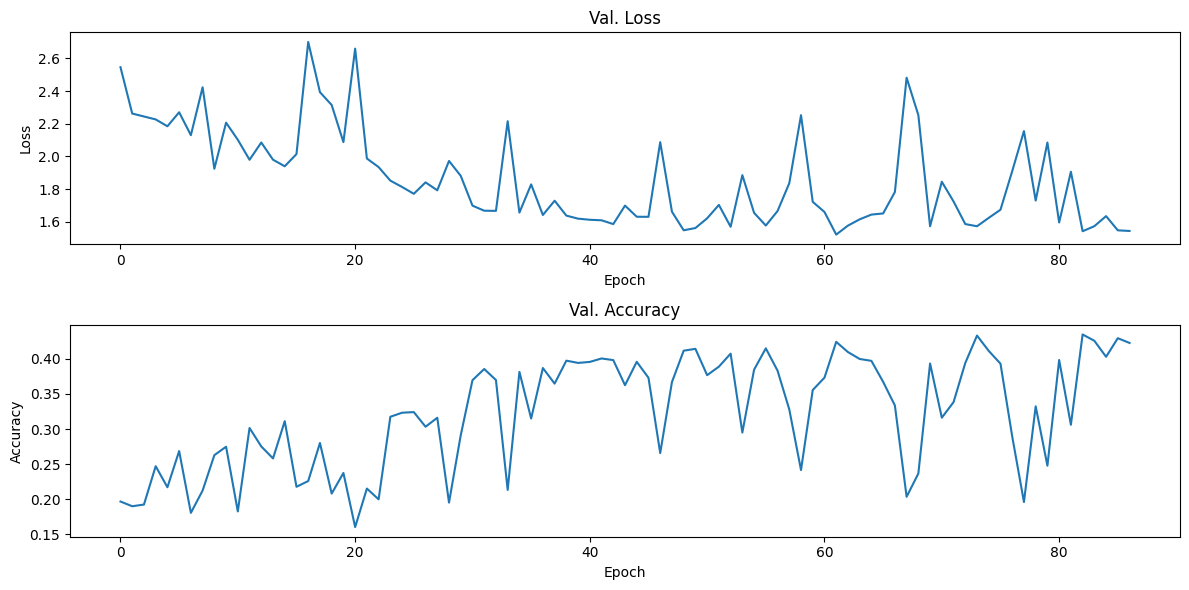

In [20]:
loss = best_bayesian_model.history['val_loss']
acc = best_bayesian_model.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title("Val. Loss")
plt.plot(loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(212)
plt.title("Val. Accuracy")
plt.plot(acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.savefig("learn.png", dpi=150)
plt.show()

In [ ]:
loss, accuracy = bayesian_model.evaluate(val_gen)
print(f'FCN-32s with {tuner[1]} tuner has loss: {loss}, accuracy: {accuracy}')

1/1 [==============================] - 0s 14ms/step


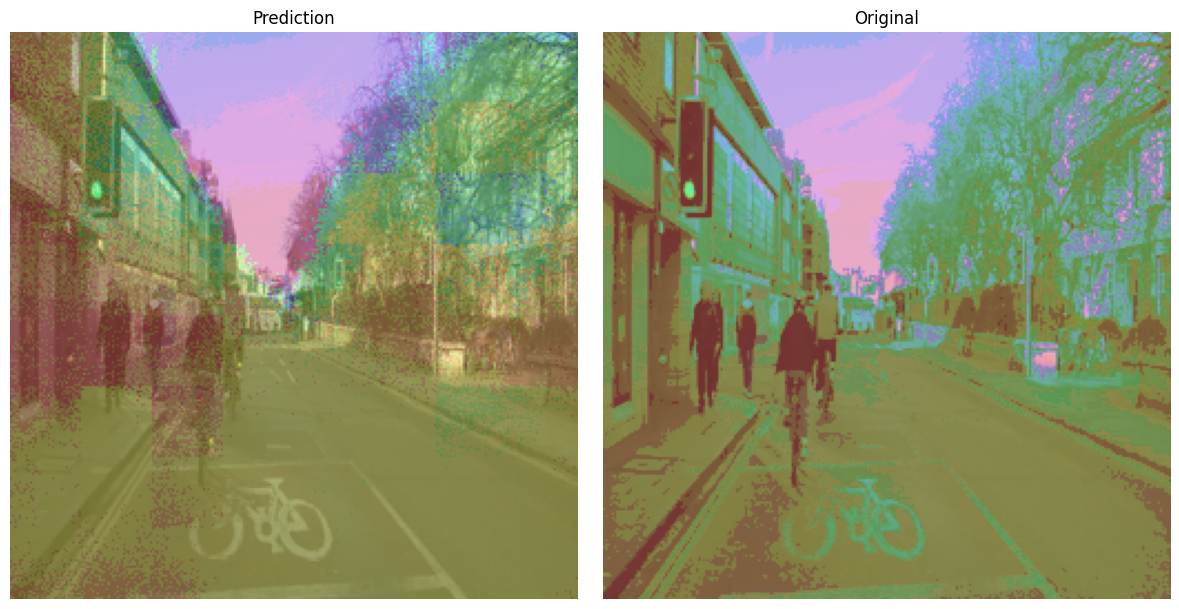

In [21]:
max_show = 1
imgs, segs = next(val_gen)
pred = bayesian_model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i] / 255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i] / 255, 0.5, _s, 0.5, 0)

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.title('Prediction')
    plt.imshow(predimg)
    plt.axis('off')
    plt.subplot(122)
    plt.title('Original')
    plt.imshow(trueimg)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('pred_' + str(tuner[1]) + '_' + str(varian[0]) + '.png', dpi=150)
    plt.show()

In [18]:
randomsearch_model = load_model('models/FCN-32s-with-randomsearch-batch_size32-epochs100.h5')

NameError: name 'best_randomsearch_model' is not defined

1/1 [==============================] - 26s 26s/step


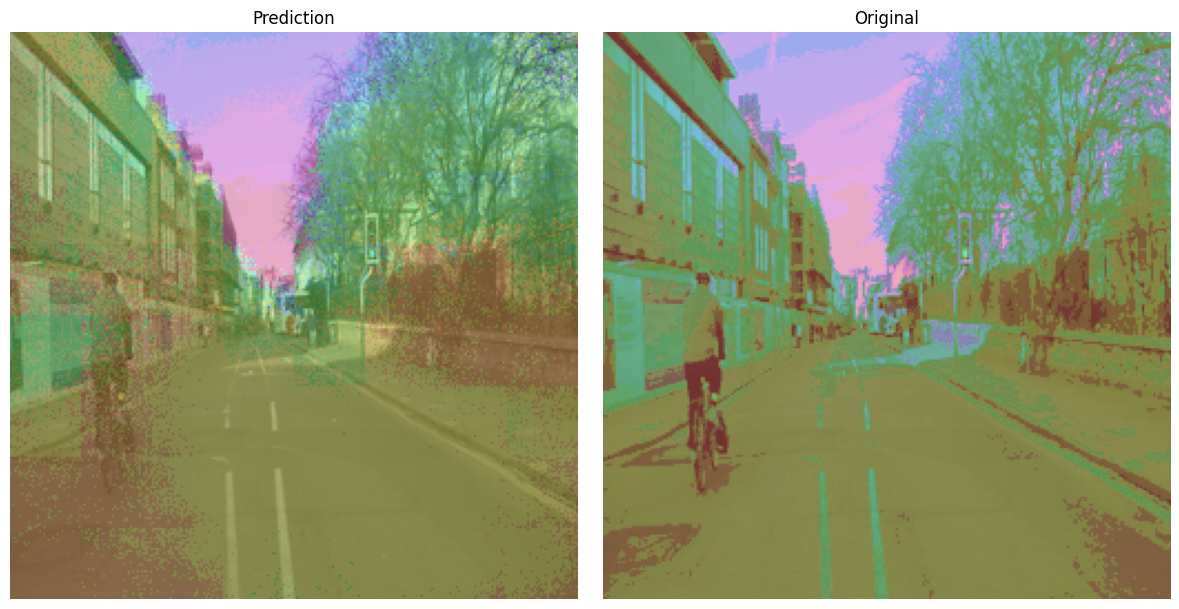

In [22]:
max_show = 1
imgs, segs = next(val_gen)
pred = randomsearch_model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i] / 255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i] / 255, 0.5, _s, 0.5, 0)

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.title('Prediction')
    plt.imshow(predimg)
    plt.axis('off')
    plt.subplot(122)
    plt.title('Original')
    plt.imshow(trueimg)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('pred_' + tuner[0] + '_' + varian[0] + '.png', dpi=150)
    plt.show()

In [23]:
hyperband_model = load_model('models/FCN-32s-with-hyperband-batch_size32-epochs100.h5')

1/1 [==============================] - 0s 84ms/step


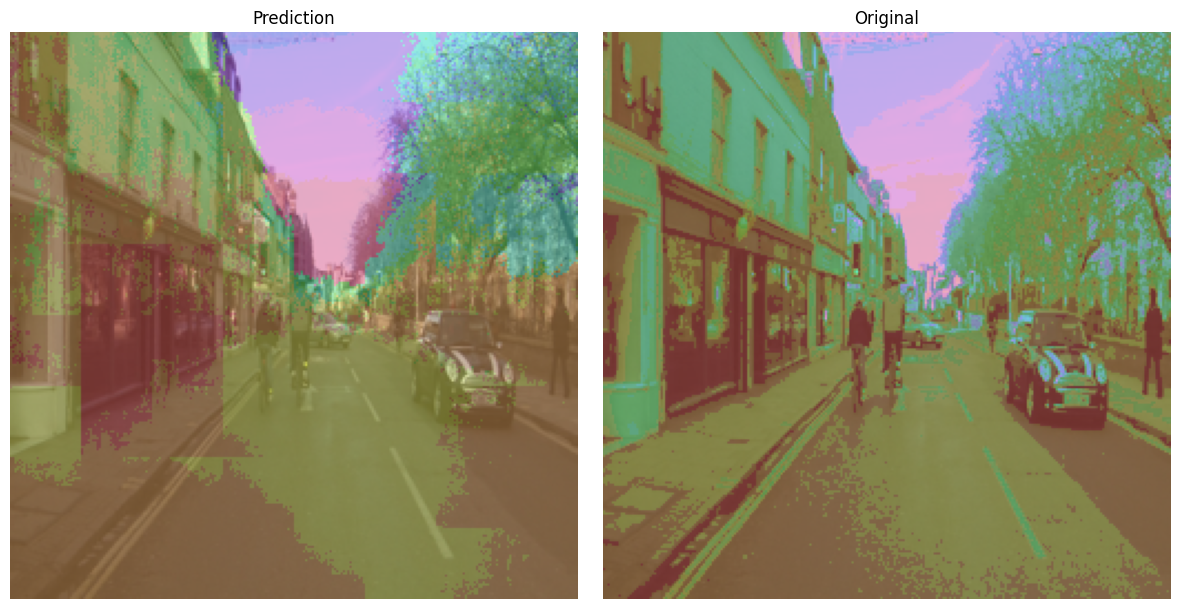

In [24]:
max_show = 1
imgs, segs = next(val_gen)
pred = hyperband_model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i] / 255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i] / 255, 0.5, _s, 0.5, 0)

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.title('Prediction')
    plt.imshow(predimg)
    plt.axis('off')
    plt.subplot(122)
    plt.title('Original')
    plt.imshow(trueimg)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('pred_' + tuner[2] + '_' + varian[0] + '.png', dpi=150)
    plt.show()

In [16]:
class BaseModel:
  def __init__(self):
    self.width = 256
    self.height = 256
    self.classes = 13
    self.epochs = 100
    self.batch_size = 32
    self.patience = 25
    self.varian = varian[0]
    self.tuner = tuner[2]
    self.early_stopping = early_stopping[0]

  def build_fcn(self):
    try:
      vgg = VGG16(include_top=False, weights='imagenet', input_shape=(self.width, self.height, 3))

      pool5 = vgg.get_layer('block5_pool').output
      pool4 = vgg.get_layer('block4_pool').output
      pool3 = vgg.get_layer('block3_pool').output

      conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
      conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)

      conv_8 = Conv2D(self.classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
      conv_9 = Conv2D(self.classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)

      deconv_7 = Conv2DTranspose(self.classes, kernel_size=(2, 2), strides=(2, 2))(conv_7)
      add_1 = Add()([deconv_7, conv_8])
      deconv_8 = Conv2DTranspose(self.classes, kernel_size=(2, 2), strides=(2, 2))(add_1)
      add_2 = Add()([deconv_8, conv_9])
      deconv_9 = Conv2DTranspose(self.classes, kernel_size=(8, 8), strides=(8, 8))(add_2)

      if self.varian == '8s':
        output_layer = Activation('softmax')(deconv_9)
      elif self.varian == '16s':
        deconv_10 = Conv2DTranspose(self.classes, kernel_size=(16, 16), strides=(16, 16))(add_1)
        output_layer = Activation('softmax')(deconv_10)
      elif self.varian == '32s':
        deconv_11 = Conv2DTranspose(self.classes, kernel_size=(32, 32), strides=(32, 32))(conv_7)
        output_layer = Activation('softmax')(deconv_11)
      else:
        raise ValueError("Select varian=['32s', '16s', '8s']")

      model = Model(inputs=vgg.input, outputs=output_layer)
        
      opt = Adam(learning_rate=0.001, decay=1e-06)
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      return model
    except ValueError as e:
      return 'Error: ' + str(e)

  def train_model(self):
    if not os.path.exists('models'):
        os.makedirs('models')

    model = self.build_fcn()
    model_name = 'models/' + str(f'FCN-{self.varian}-with-BaseModel-batch_size{self.batch_size}-epochs{self.epochs}.h5')
    model_name = rename_file_if_exists(model_name)

    cp = ModelCheckpoint(f'{model_name}', monitor='val_loss', save_best_only=True,
                          save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)

    early_stopping = EarlyStopping(monitor='val_loss', patience=self.patience)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=self.patience)

    history = model.fit(train_gen, epochs=self.epochs, steps_per_epoch=(num_of_training_samples // self.batch_size),
                        validation_data=val_gen, validation_steps=(num_of_testing_samples // self.batch_size),
                        batch_size=self.batch_size, callbacks=[cp, early_stopping, reduce_lr], shuffle=True)

    return history

In [17]:
train_model = BaseModel()
history = train_model.train_model()

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 13.5537 - accuracy: 0.1181
Epoch 1: val_loss improved from inf to 2.55708, saving model to models\FCN-32s-with-BaseModel-batch_size32-epochs100.h5
11/11 [==============================] - 268s 9s/step - loss: 13.5537 - accuracy: 0.1181 - val_loss: 2.5571 - val_accuracy: 0.1735 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 2.4874 - accuracy: 0.1609
Epoch 2: val_loss improved from 2.55708 to 2.25039, saving model to models\FCN-32s-with-BaseModel-batch_size32-epochs100.h5
11/11 [==============================] - 7s 690ms/step - loss: 2.4874 - accuracy: 0.1609 - val_loss: 2.2504 - val_accuracy: 0.2964 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 2.5855 - accuracy: 0.1833
Epoch 3: val_loss did not improve from 2.25039
11/11 [==============================] - 6s 600ms/step - loss: 2.5855 - accuracy: 0.1833 - val_loss: 2.5152 - val_accuracy: 0.1525 - lr

In [18]:
base_model = load_model('models/FCN-32s-with-BaseModel-batch_size32-epochs100.h5')

1/1 [==============================] - 0s 107ms/step


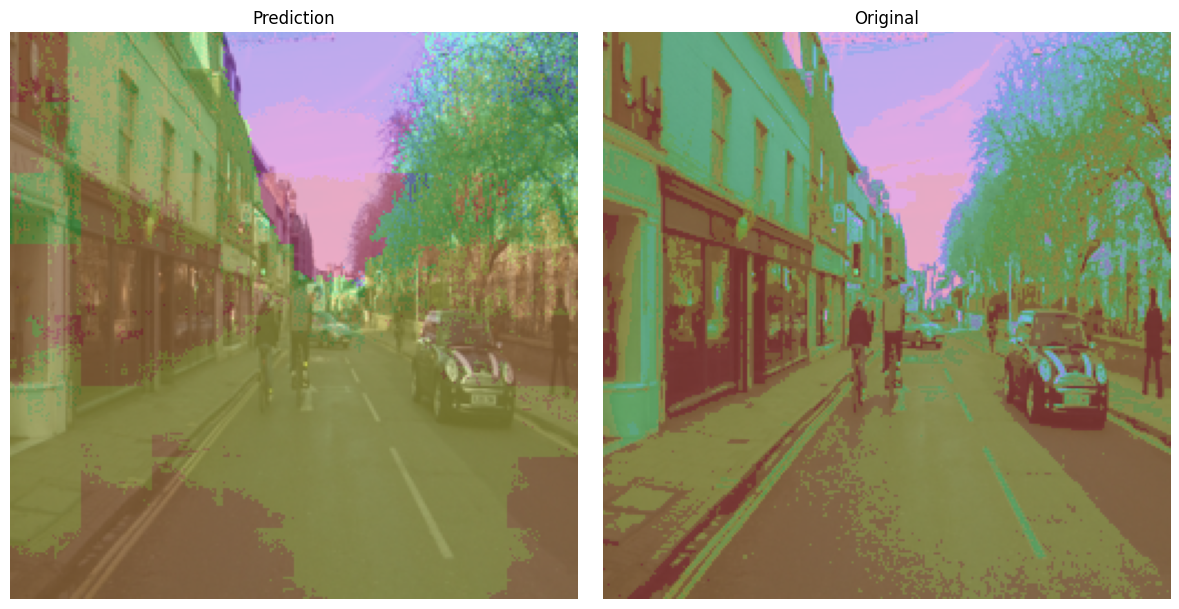

In [19]:
max_show = 1
imgs, segs = next(val_gen)
pred = base_model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i] / 255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i] / 255, 0.5, _s, 0.5, 0)

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.title('Prediction')
    plt.imshow(predimg)
    plt.axis('off')
    plt.subplot(122)
    plt.title('Original')
    plt.imshow(trueimg)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('pred_BaseModel_' + varian[0] + '.png', dpi=150)
    plt.show()